In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import matplotlib.pyplot as plt


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Standard error of autocorrelation


In [4]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`


In [5]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result


### Plot of autocorrelation function


In [6]:
def plot_autocorr_func(df_acorr_analysis):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title("Autocorrelation Function for Yt\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)



In [9]:
filename = "02-table-05-rowise-quarterly-sales-for-coastal-marine.ods"

df = read_ods(filename, {"t": "t", "Sales": "Y_t"})
df.head()


,t,Y_t
0,1,147.6
1,2,251.8
2,3,273.1
3,4,249.1
4,5,139.3


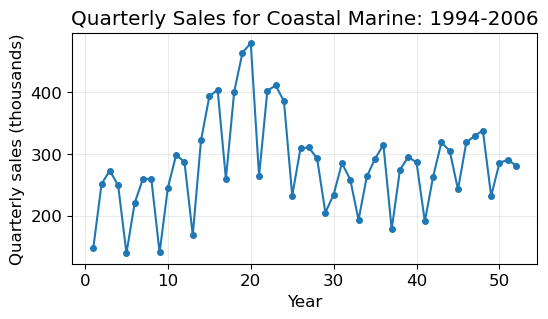

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Year")
ax.set_ylabel("Quarterly sales (thousands)")
ax.set_title("Quarterly Sales for Coastal Marine: 1994-2006")
ax.grid("on")
plt.show(fig)


In [12]:
num_of_rk = 13
df_acorr_analysis = get_correlogram(df, num_of_rk, columns=['t', "Y_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.392861,2.832960,8.497758,-0.278402,0.278402
1,2,0.153945,0.970400,9.828697,-0.318485,0.318485
2,3,0.293782,1.819217,14.774666,-0.324201,0.324201
3,4,0.743520,4.336447,47.114729,-0.344217,0.344217
4,5,0.150655,0.669345,48.470753,-0.451864,0.451864
5,6,-0.153008,-0.674017,49.899872,-0.455740,0.455740
6,7,-0.046978,-0.205160,50.037586,-0.459705,0.459705
7,8,0.346975,1.514055,57.720768,-0.460077,0.460077
8,9,-0.182601,-0.763834,59.898153,-0.479930,0.479930
9,10,-0.434729,-1.798438,72.533449,-0.485285,0.485285


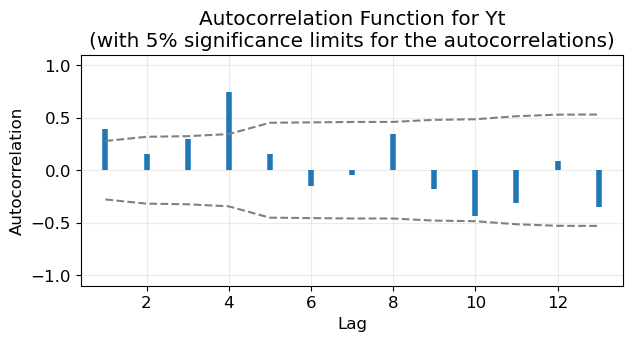

In [13]:
plot_autocorr_func(df_acorr_analysis)
